## Short Introduction

The dataset under analysis contains features describing loan candidates, and the task is to predict whether a candidate is eligible for a loan or not. The goal is to develop a robust model that can either:

* Automate the classification process to make quick and consistent decisions, or
* Assist human decision-makers by providing insights into a candidate's eligibility.

In the latter case, the model can present results as probabilities, enabling humans to assess the confidence level of each prediction and make informed decisions. This approach ensures flexibility in deploying the solution across different use cases, from fully automated systems to decision-support tools.



## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
import warnings
from matplotlib.colors import LinearSegmentedColormap
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.compose import ColumnTransformer, make_column_selector
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold,cross_val_score, cross_val_predict
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    precision_recall_curve, 
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    PrecisionRecallDisplay
)
import time
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import joblib

## Importing Data

In [2]:
df = pd.read_csv("/kaggle/input/loan-approval-classification-data/loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

## Train/Test Split

In [4]:
target_variable = "loan_status"

train_set, test_set = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df[target_variable], 
    random_state=42
)

print("Class distribution in original dataset:")
print(df[target_variable].value_counts(normalize=True))

print("\nClass distribution in training set:")
print(train_set[target_variable].value_counts(normalize=True))

print("\nClass distribution in testing set:")
print(test_set[target_variable].value_counts(normalize=True))

Class distribution in original dataset:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64

Class distribution in training set:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64

Class distribution in testing set:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


## Exploratory Data Analysis

In [5]:
loan = train_set.copy()
loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36000 entries, 6048 to 44095
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      36000 non-null  float64
 1   person_gender                   36000 non-null  object 
 2   person_education                36000 non-null  object 
 3   person_income                   36000 non-null  float64
 4   person_emp_exp                  36000 non-null  int64  
 5   person_home_ownership           36000 non-null  object 
 6   loan_amnt                       36000 non-null  float64
 7   loan_intent                     36000 non-null  object 
 8   loan_int_rate                   36000 non-null  float64
 9   loan_percent_income             36000 non-null  float64
 10  cb_person_cred_hist_length      36000 non-null  float64
 11  credit_score                    36000 non-null  int64  
 12  previous_loan_defaults_on_file  36

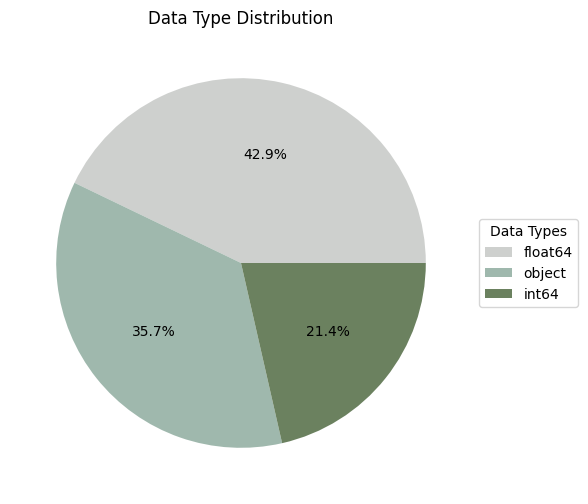

In [6]:
def plot_dtype_distribution(df):

    dtype_counts = df.dtypes.value_counts()

    total_columns = len(df.columns)
    dtype_percentages = (dtype_counts / total_columns) * 100

    colors = ["#CED0CE", "#9FB8AD", "#6B815F"]
    
    plt.figure(figsize=(8,6))
    wedges, texts, autotexts = plt.pie(dtype_percentages, colors = colors, autopct="%.1f%%", startangle=0)
    plt.legend(wedges, dtype_counts.index, title="Data Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title("Data Type Distribution")
    plt.show()

plot_dtype_distribution(loan)

In [7]:
def plot_missing_values(df):

    missing_percentages = (df.isnull().sum() / len(df)) * 100
    missing_percentages = missing_percentages[missing_percentages > 0]

    if not missing_percentages.empty:
        plt.figure(figsize=(10,6))
        missing_percentages.sort_values().plot(kind = "bar", color = "#9FB8AD")
        plt.xlabel("Columns")
        plt.ylabel("% of missing values")
        plt.title("Percentage of Missing Values in Each Column")
        plt.xticks(rotation=45, ha = "right")
        plt.tight_layout()
        plt.show()

    else:
        print("No columns with missing values!")

plot_missing_values(loan)

No columns with missing values!


In [8]:
def show_column_info(df):

    column_info = {
        "Column": [],
        "Data Type": [],
        "Unique Values": []
    }

    for column in df.columns:
        column_info["Column"].append(column)
        column_info["Data Type"].append(df[column].dtype)
        column_info["Unique Values"].append(df[column].nunique())

    column_info_df = pd.DataFrame(column_info)
    return print(column_info_df)

show_column_info(loan)

                            Column Data Type  Unique Values
0                       person_age   float64             58
1                    person_gender    object              2
2                 person_education    object              5
3                    person_income   float64          28534
4                   person_emp_exp     int64             61
5            person_home_ownership    object              4
6                        loan_amnt   float64           3742
7                      loan_intent    object              6
8                    loan_int_rate   float64           1277
9              loan_percent_income   float64             64
10      cb_person_cred_hist_length   float64             29
11                    credit_score     int64            335
12  previous_loan_defaults_on_file    object              2
13                     loan_status     int64              2


In [9]:
def show_frequent_values(df, threshold):
    for column in df.columns:
        value_counts = df[column].value_counts(normalize=True) * 100
        frequent_values = value_counts[value_counts >= threshold]

        if not frequent_values.empty:
            print(frequent_values)
            print()

show_frequent_values(loan, 15)

person_gender
male      54.961111
female    45.038889
Name: proportion, dtype: float64

person_education
Bachelor       29.827778
Associate      26.863889
High School    26.394444
Master         15.497222
Name: proportion, dtype: float64

person_emp_exp
0    21.319444
Name: proportion, dtype: float64

person_home_ownership
RENT        52.027778
MORTGAGE    41.125000
Name: proportion, dtype: float64

loan_intent
EDUCATION            20.266667
MEDICAL              19.183333
VENTURE              17.300000
PERSONAL             16.630556
DEBTCONSOLIDATION    15.966667
Name: proportion, dtype: float64

cb_person_cred_hist_length
4.0    19.305556
3.0    18.505556
Name: proportion, dtype: float64

previous_loan_defaults_on_file
Yes    50.730556
No     49.269444
Name: proportion, dtype: float64

loan_status
0    77.777778
1    22.222222
Name: proportion, dtype: float64



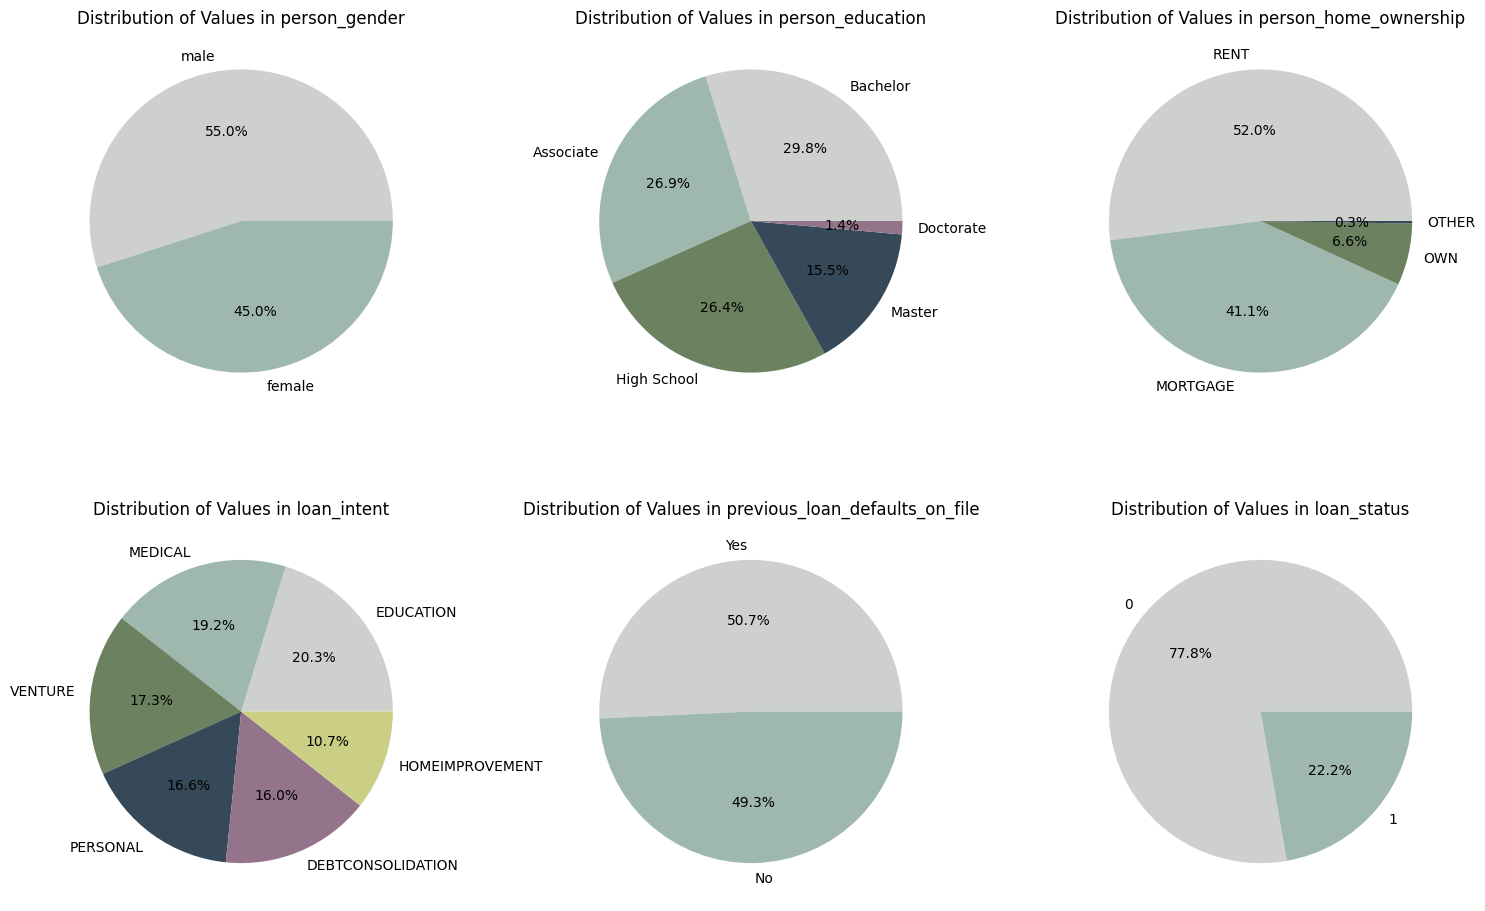

In [10]:
def pie_chart_of_columns(df, max_unique_values):
    
    columns_to_plot = [column for column in df.columns if df[column].nunique() < max_unique_values]

    num_plots = len(columns_to_plot)

    num_rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)

    plt.figure(figsize=(15, num_rows * 5))
    
    for idx, column in enumerate(columns_to_plot, 1):
        value_counts = df[column].value_counts(normalize=True) * 100

        plt.subplot(num_rows, 3, idx)
        plt.pie(value_counts, labels=value_counts.index, autopct="%.1f%%", startangle=0, 
                colors=["#CED0CE", "#9FB8AD", "#6B815F", "#364958", "#93748A","#CACF85"])
        plt.title(f"Distribution of Values in {column}")

    plt.tight_layout()
    plt.show()

pie_chart_of_columns(loan, 7)

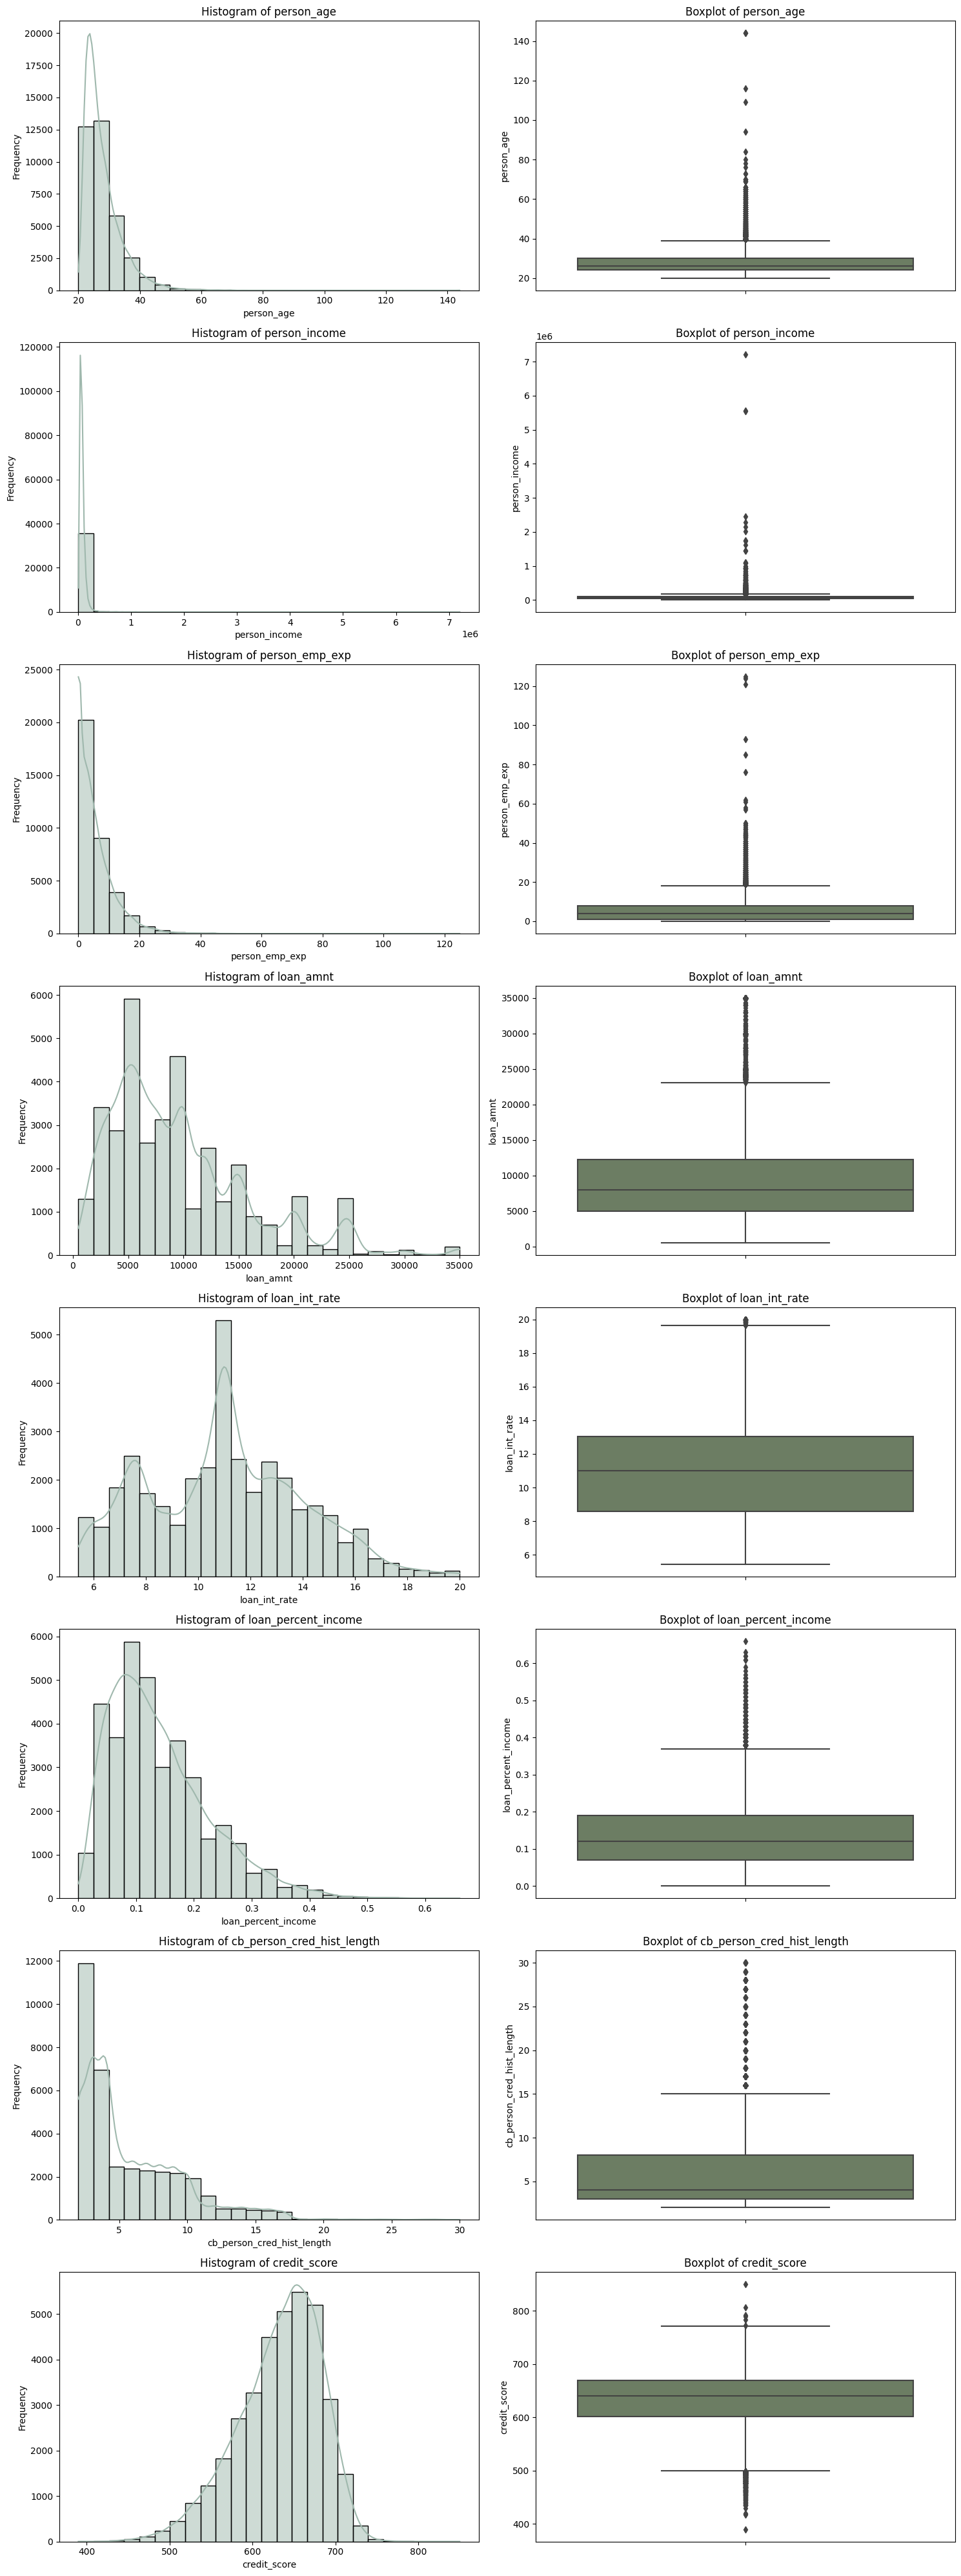

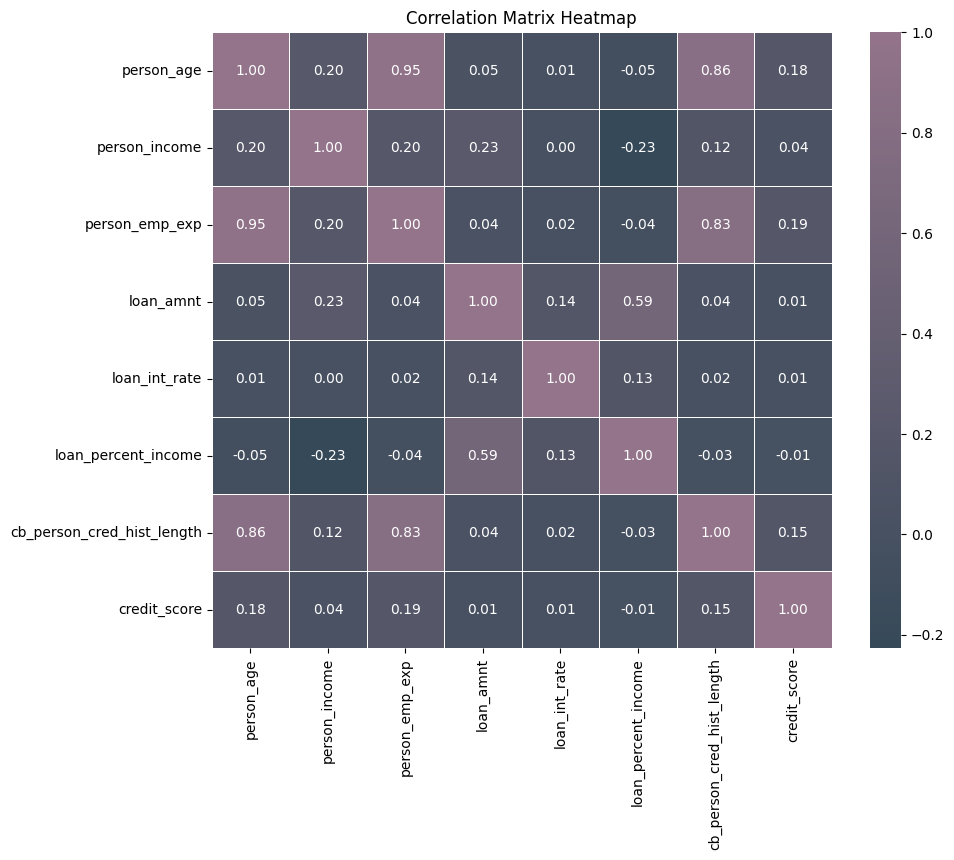

,count,mean,std,min,25%,50%,75%,max
person_age,36000.0,27.763194,6.045354,20.00,24.00,26.00,30.0000,144.00
person_income,36000.0,80549.469361,84316.972457,8000.00,47163.50,67081.00,96260.7500,7200766.00
person_emp_exp,36000.0,5.405611,6.064240,0.00,1.00,4.00,8.0000,125.00
loan_amnt,36000.0,9586.962861,6301.447426,500.00,5000.00,8000.00,12235.0000,35000.00
loan_int_rate,36000.0,11.013158,2.976288,5.42,8.59,11.01,13.0225,20.00
loan_percent_income,36000.0,0.139635,0.086949,0.00,0.07,0.12,0.1900,0.66
cb_person_cred_hist_length,36000.0,5.863444,3.878709,2.00,3.00,4.00,8.0000,30.00
credit_score,36000.0,632.649583,50.292346,390.00,602.00,640.00,670.0000,850.00


In [11]:
warnings.simplefilter(action='ignore', category=FutureWarning)

custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#364958", "#93748A"])

def analyze_filtered_data(df, min_unique_values, bins):

    filtered_columns = [column for column in df.columns if df[column].nunique() > min_unique_values]
    filtered_data = df[filtered_columns]

    
    num_columns = len(filtered_columns)
    plots_per_row = 2  

    fig, axes = plt.subplots(num_columns, plots_per_row, figsize=(15, 5 * num_columns))
    axes = axes.flatten()

    for idx, column in enumerate(filtered_columns):
        
        sns.histplot(filtered_data[column], bins=bins, kde=True, ax=axes[2 * idx], color="#9FB8AD")
        axes[2 * idx].set_title(f"Histogram of {column}")
        axes[2 * idx].set_xlabel(column)
        axes[2 * idx].set_ylabel("Frequency")

       
        sns.boxplot(y=filtered_data[column], ax=axes[2 * idx + 1], color="#6B815F")
        axes[2 * idx + 1].set_title(f"Boxplot of {column}")
        axes[2 * idx + 1].set_ylabel(column)

  
    for idx in range(num_columns * 2, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

   
    corr_matrix = filtered_data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap=custom_cmap, fmt=".2f", cbar=True, linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()
    return filtered_data.describe().transpose()

analyze_filtered_data(loan, 7, 25)

In [12]:
filtered_loan = loan[loan["person_age"] <= 100]

filtered_loan.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
6048,24.0,male,Master,58914.0,2,OWN,4400.0,VENTURE,5.99,0.07,4.0,656,Yes,0
3346,23.0,female,High School,45873.0,2,RENT,11000.0,VENTURE,11.01,0.24,2.0,634,Yes,0
17998,29.0,female,Master,240947.0,7,MORTGAGE,10000.0,VENTURE,12.69,0.04,9.0,638,Yes,0
24988,30.0,female,Bachelor,96316.0,10,MORTGAGE,6000.0,MEDICAL,13.49,0.06,8.0,682,No,0
23231,29.0,male,Bachelor,73033.0,7,MORTGAGE,8000.0,PERSONAL,10.51,0.11,8.0,644,Yes,0


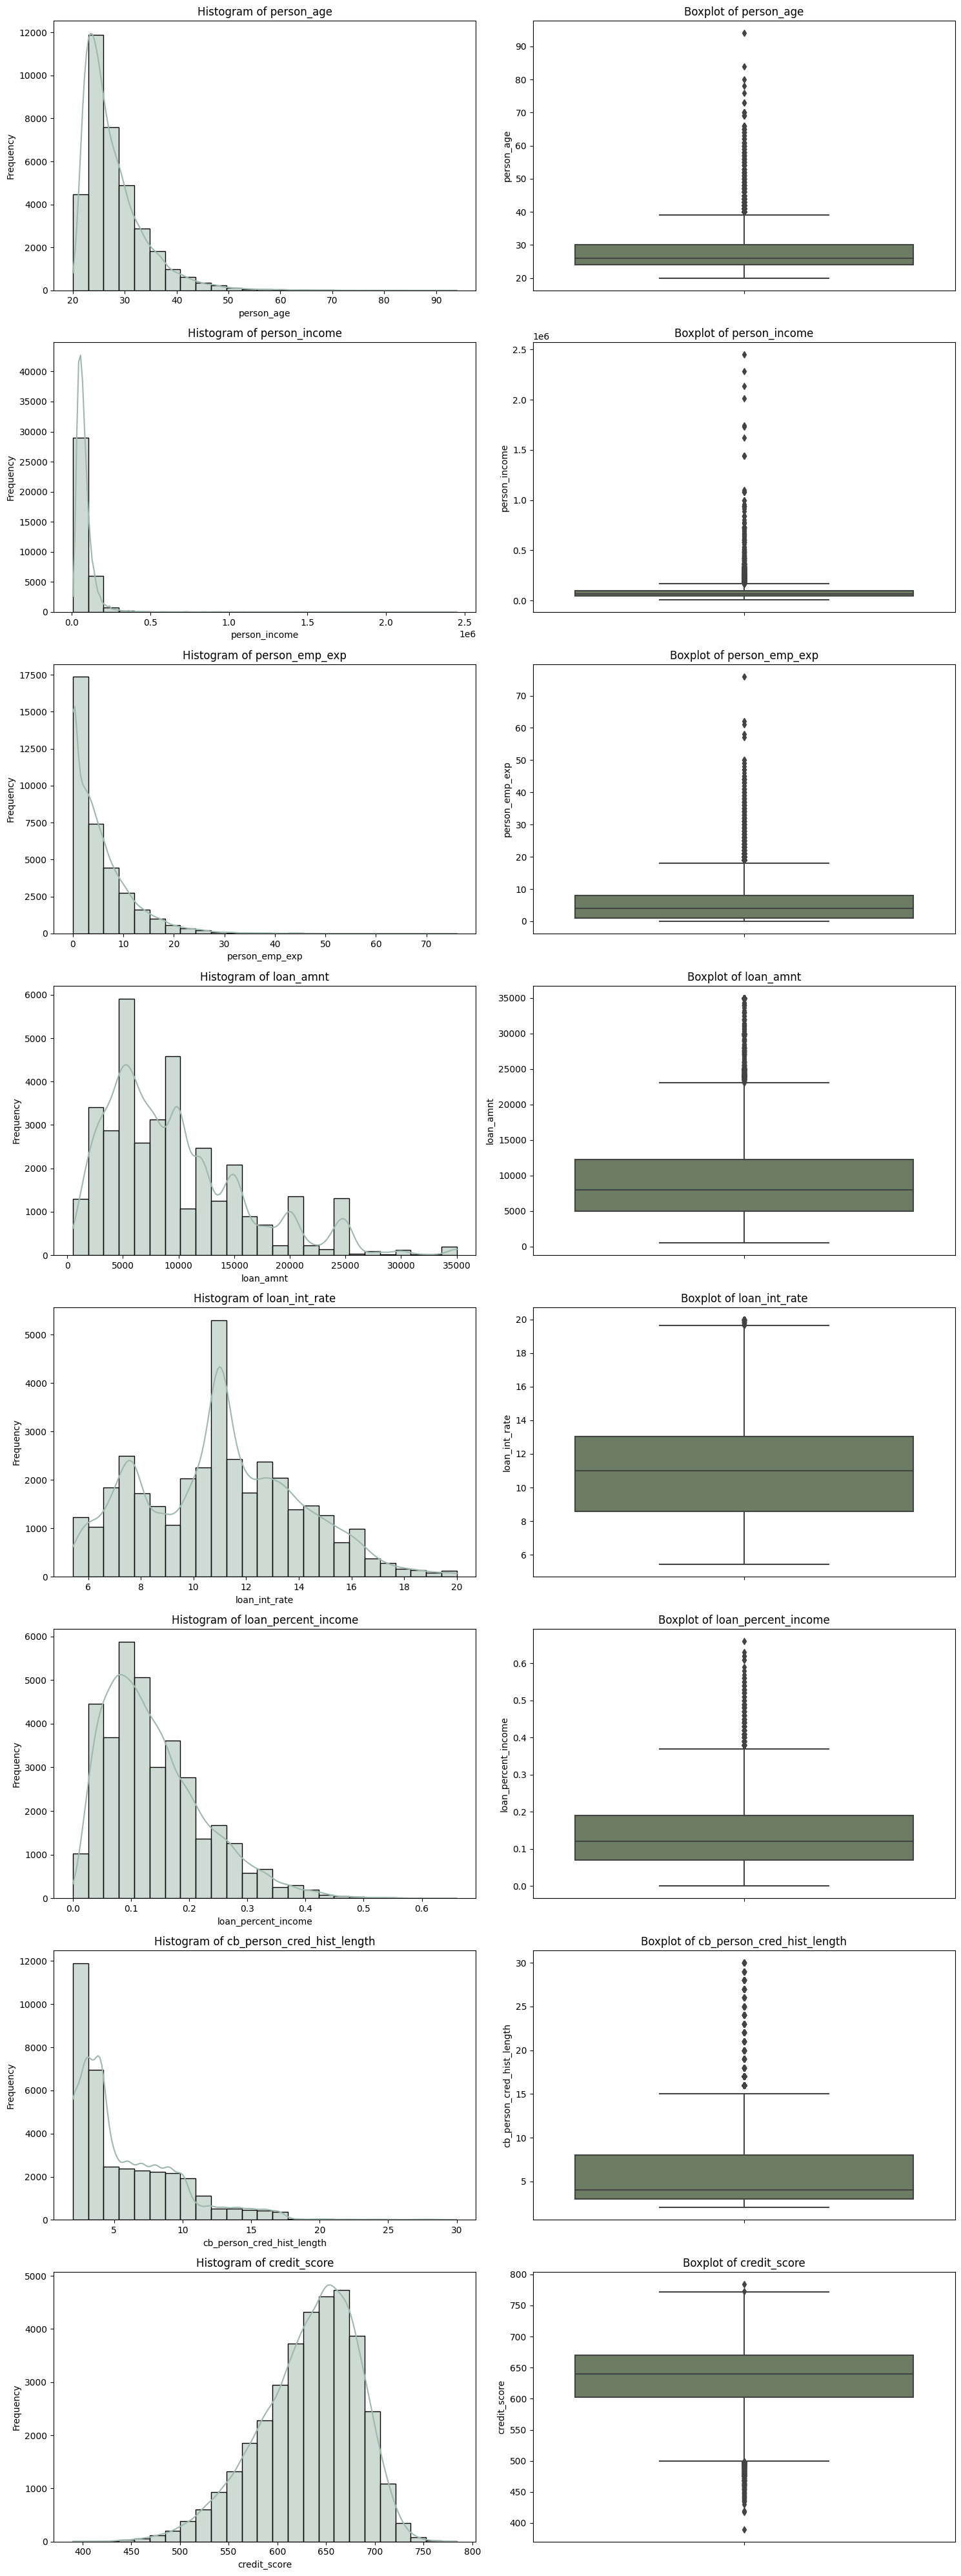

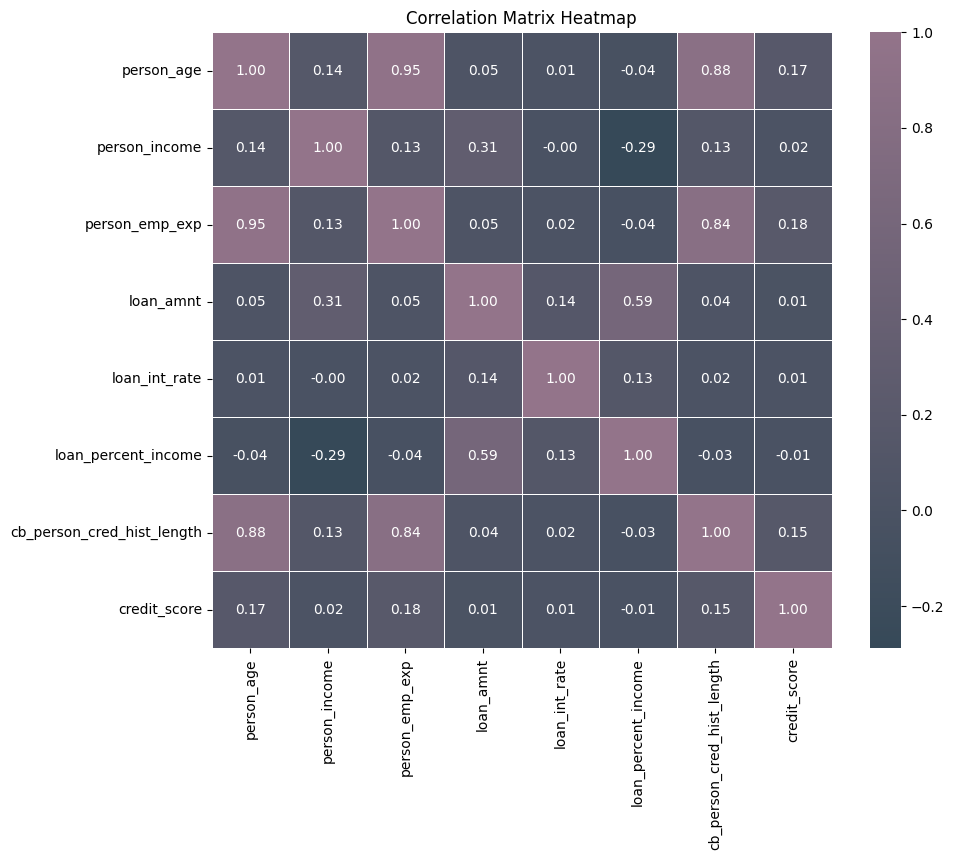

,count,mean,std,min,25%,50%,75%,max
person_age,35995.0,27.748798,5.918227,20.00,24.00,26.00,30.000,94.00
person_income,35995.0,80037.120350,63535.080198,8000.00,47161.50,67077.00,96214.000,2448661.00
person_emp_exp,35995.0,5.391138,5.935602,0.00,1.00,4.00,8.000,76.00
loan_amnt,35995.0,9587.577302,6301.661204,500.00,5000.00,8000.00,12236.000,35000.00
loan_int_rate,35995.0,11.012941,2.976429,5.42,8.59,11.01,13.025,20.00
loan_percent_income,35995.0,0.139653,0.086941,0.00,0.07,0.12,0.190,0.66
cb_person_cred_hist_length,35995.0,5.862148,3.875472,2.00,3.00,4.00,8.000,30.00
credit_score,35995.0,632.627837,50.259045,390.00,602.00,640.00,670.000,784.00


In [13]:
analyze_filtered_data(filtered_loan, 7, 25)

## Data Preprocessing

In [14]:
print(filtered_loan["loan_int_rate"].mode())

0    11.01
Name: loan_int_rate, dtype: float64


In [15]:
X_train = filtered_loan.drop(["loan_status"], axis=1)
y_train = filtered_loan["loan_status"].copy()

In [16]:
def log_transform(X):
    return np.log(X + 1e-9)
    
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                             OneHotEncoder(drop="first", handle_unknown="ignore"))

log_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                             FunctionTransformer(log_transform, feature_names_out="one-to-one"),
                             StandardScaler())
rbf_pipeline = make_pipeline(SimpleImputer(strategy="median"), FunctionTransformer(rbf_kernel, 
                                                                                   kw_args=dict(Y=[[11.01]], gamma=0.1),
                                                                                   feature_names_out="one-to-one"),)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, make_column_selector(dtype_include = object)),
    ("log", log_pipeline, ["person_age", "person_income", "person_emp_exp", 
                           "loan_amnt", "loan_percent_income"]),
    
    ("rbf", rbf_pipeline, ["loan_int_rate"]),
],
    remainder=default_num_pipeline)

In [17]:
X_transformed = preprocessing.fit_transform(X_train)

In [18]:
X_transformed.shape

(35995, 22)

In [19]:
preprocessing.get_feature_names_out()

array(['cat__person_gender_male', 'cat__person_education_Bachelor',
       'cat__person_education_Doctorate',
       'cat__person_education_High School',
       'cat__person_education_Master', 'cat__person_home_ownership_OTHER',
       'cat__person_home_ownership_OWN',
       'cat__person_home_ownership_RENT', 'cat__loan_intent_EDUCATION',
       'cat__loan_intent_HOMEIMPROVEMENT', 'cat__loan_intent_MEDICAL',
       'cat__loan_intent_PERSONAL', 'cat__loan_intent_VENTURE',
       'cat__previous_loan_defaults_on_file_Yes', 'log__person_age',
       'log__person_income', 'log__person_emp_exp', 'log__loan_amnt',
       'log__loan_percent_income', 'rbf__loan_int_rate',
       'remainder__cb_person_cred_hist_length', 'remainder__credit_score'],
      dtype=object)

In [20]:
X_transformed_df = pd.DataFrame(data=X_transformed, columns=preprocessing.get_feature_names_out())
X_transformed_df.head()

,cat__person_gender_male,cat__person_education_Bachelor,cat__person_education_Doctorate,cat__person_education_High School,cat__person_education_Master,cat__person_home_ownership_OTHER,cat__person_home_ownership_OWN,cat__person_home_ownership_RENT,cat__loan_intent_EDUCATION,cat__loan_intent_HOMEIMPROVEMENT,...,cat__loan_intent_VENTURE,cat__previous_loan_defaults_on_file_Yes,log__person_age,log__person_income,log__person_emp_exp,log__loan_amnt,log__loan_percent_income,rbf__loan_int_rate,remainder__cb_person_cred_hist_length,remainder__credit_score
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,-0.666443,-0.249120,0.422206,-0.779166,-0.584286,0.080456,-0.480502,0.465040
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,-0.891671,-0.697416,0.422206,0.511980,0.946523,1.000000,-0.996576,0.027302
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.335037,2.274538,0.558871,0.377678,-1.279549,0.754093,0.809681,0.106891
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.514446,0.631618,0.597781,-0.342126,-0.775802,0.540619,0.551644,0.982367
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.335037,0.135803,0.558871,0.063247,-0.022742,0.975310,0.551644,0.226274


## Model Selection

In [21]:
xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=1.38,
    learning_rate=0.0959,
    max_depth=7,
    n_estimators=164,
    reg_alpha=0.0156,
    reg_lambda=0.4234,
    subsample=0.6974,
    random_state=42
)


models = {
    "Logistic Regression": make_pipeline(preprocessing, LogisticRegression(max_iter=500, random_state=42)),
    "AdaBoost": make_pipeline(preprocessing, AdaBoostClassifier(n_estimators=100, random_state=42)),
    "LightGBM": make_pipeline(preprocessing, LGBMClassifier(random_state=42, verbose=-1)),
    "CatBoost": make_pipeline(preprocessing, CatBoostClassifier(verbose=0, random_state=42)),
    "XGBClassifier": make_pipeline(preprocessing, xgb_model),
    "Gradient Boosting": make_pipeline(preprocessing, 
                                           GradientBoostingClassifier(random_state=42)),
}

In [22]:
def evaluate_models(models, X_train, y_train):
    results = []
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    

    for name, model in models.items():
        print(f"\nEvaluating model: {name}")
        
        start_time = time.time()
        
        y_pred = cross_val_predict(model, X_train, y_train, cv=stratified_cv, method="predict")
        y_proba = cross_val_predict(model, X_train, y_train, cv=stratified_cv, method="predict_proba")[:, 1]

        end_time = time.time()
        print(f"Training time for {name}: {end_time - start_time:.2f} seconds")
        
        acc = accuracy_score(y_train, y_pred)
        roc_auc = roc_auc_score(y_train, y_proba)
        f1 = f1_score(y_train, y_pred)
        
        precision, recall, _ = precision_recall_curve(y_train, y_proba)
       
        cm = confusion_matrix(y_train, y_pred)
        
        results.append({
            "Model": name,
            "Accuracy": acc,
            "ROC-AUC": roc_auc,
            "F1 Score": f1,
            "Confusion Matrix": cm
        })
        
        
        print(f"Accuracy: {acc:.4f}, ROC-AUC: {roc_auc:.4f}, F1 Score: {f1:.4f}")
        disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp_cm.plot(cmap="Blues")
        plt.title(f"{name} - Confusion Matrix")
        plt.show()
        
        disp_pr = PrecisionRecallDisplay(precision=precision, recall=recall)
        disp_pr.plot()
        plt.title(f"{name} - Precision-Recall Curve")
        plt.show()
    
   
    results_df = pd.DataFrame(results)
    return results_df


Evaluating model: Logistic Regression
Training time for Logistic Regression: 6.10 seconds
Accuracy: 0.8766, ROC-AUC: 0.9378, F1 Score: 0.7190


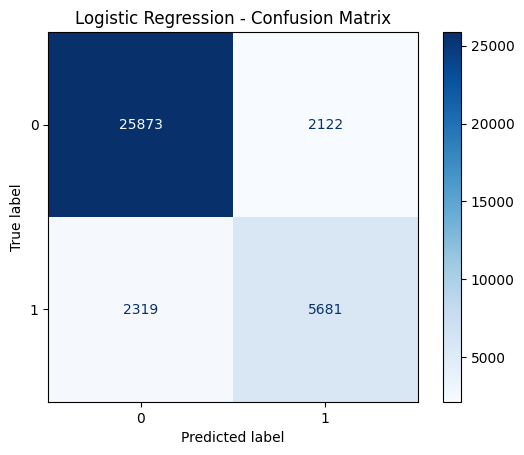

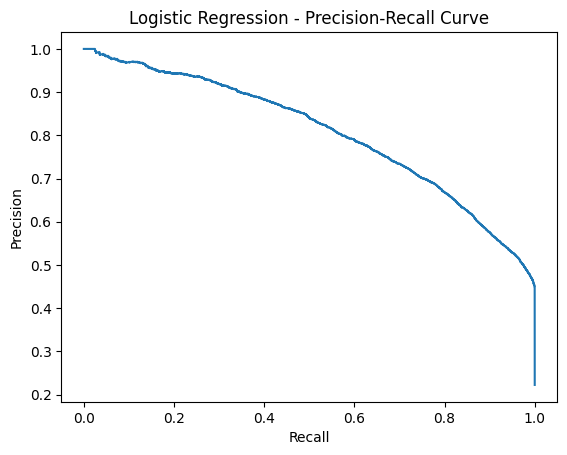


Evaluating model: AdaBoost
Training time for AdaBoost: 30.64 seconds
Accuracy: 0.9012, ROC-AUC: 0.9546, F1 Score: 0.7626


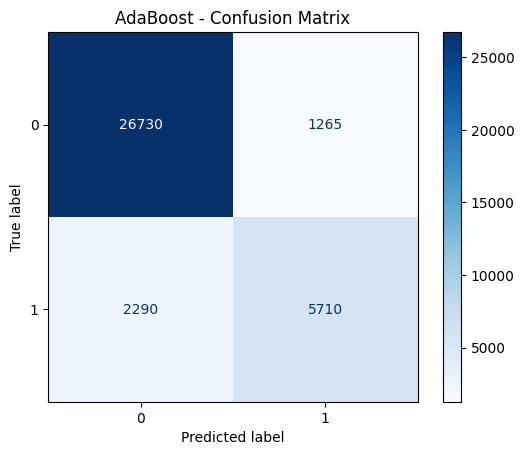

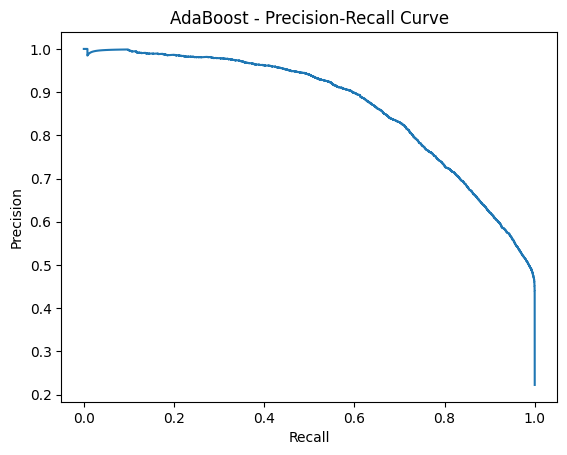


Evaluating model: LightGBM
Training time for LightGBM: 4.29 seconds
Accuracy: 0.9202, ROC-AUC: 0.9702, F1 Score: 0.8050


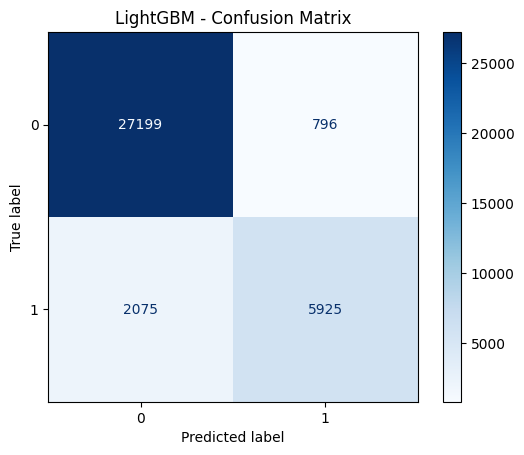

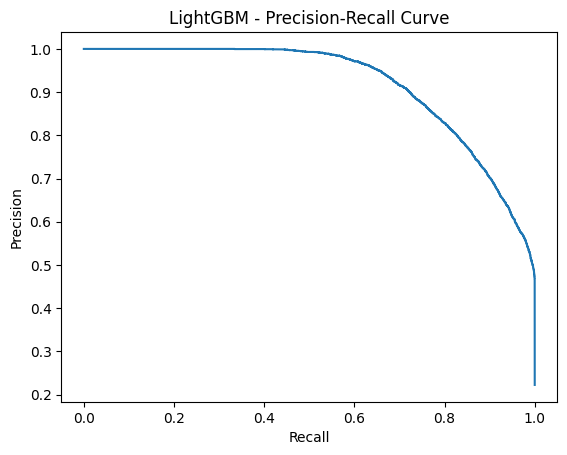


Evaluating model: CatBoost
Training time for CatBoost: 74.03 seconds
Accuracy: 0.9224, ROC-AUC: 0.9712, F1 Score: 0.8103


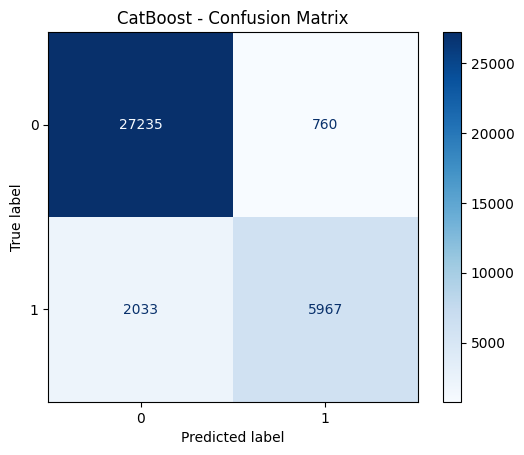

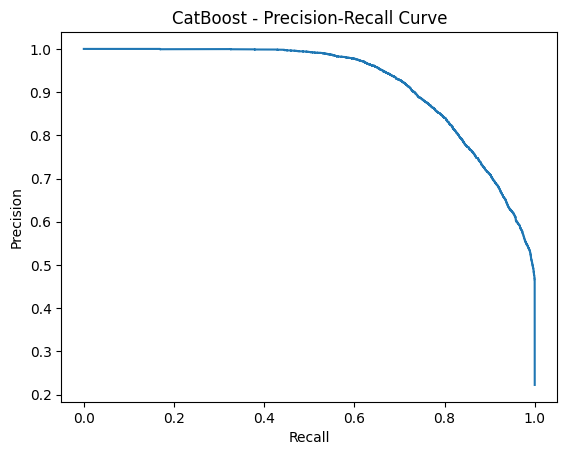


Evaluating model: XGBClassifier
Training time for XGBClassifier: 5.69 seconds
Accuracy: 0.9207, ROC-AUC: 0.9702, F1 Score: 0.8078


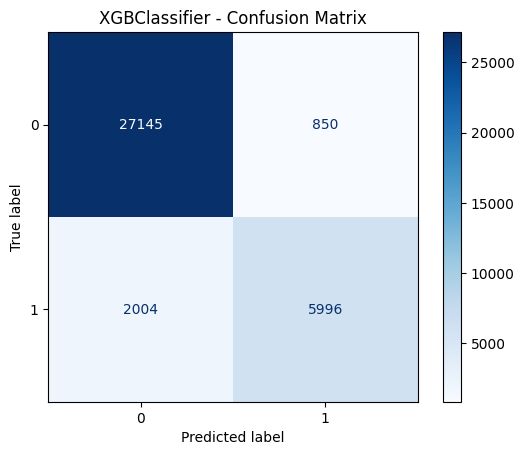

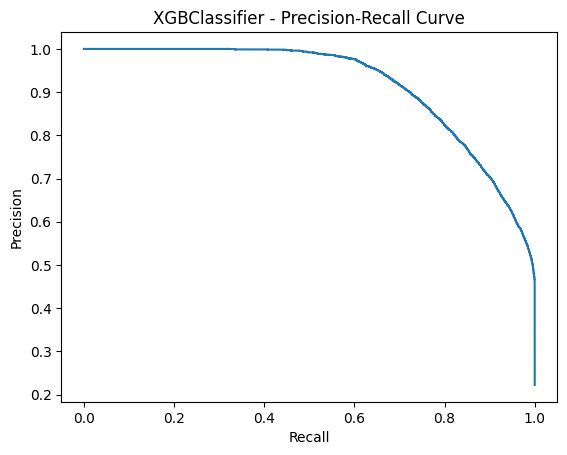


Evaluating model: Gradient Boosting
Training time for Gradient Boosting: 55.98 seconds
Accuracy: 0.9087, ROC-AUC: 0.9607, F1 Score: 0.7700


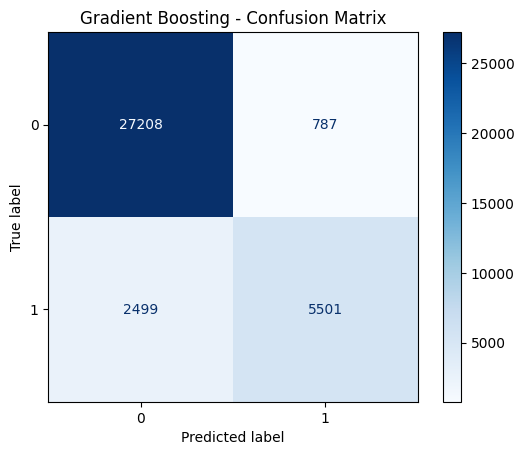

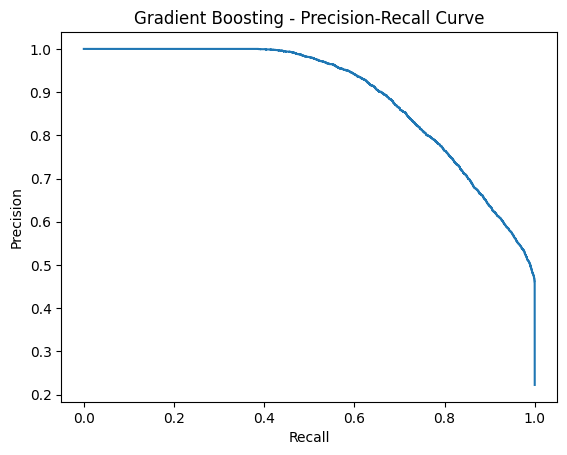

,Model,Accuracy,ROC-AUC,F1 Score,Confusion Matrix
0,Logistic Regression,0.876622,0.937766,0.718977,"[[25873, 2122], [2319, 5681]]"
1,AdaBoost,0.901236,0.954589,0.762604,"[[26730, 1265], [2290, 5710]]"
2,LightGBM,0.920239,0.970177,0.804972,"[[27199, 796], [2075, 5925]]"
3,CatBoost,0.922406,0.971211,0.810348,"[[27235, 760], [2033, 5967]]"
4,XGBClassifier,0.920711,0.970200,0.807760,"[[27145, 850], [2004, 5996]]"
5,Gradient Boosting,0.908710,0.960655,0.770017,"[[27208, 787], [2499, 5501]]"


In [23]:
evaluate_models(models, X_train, y_train)

## Hyperparameter Tuning

In [24]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": Pipeline([
        ("preprocessing", preprocessing),
        ("log_reg", LogisticRegression(random_state=42)),
    ]),
    "AdaBoost": Pipeline([
        ("preprocessing", preprocessing),
        ("adaboost", AdaBoostClassifier(random_state=42)),
    ]),
    "LightGBM": Pipeline([
        ("preprocessing", preprocessing),
        ("lgbm", LGBMClassifier(random_state=42, verbose=-1)),
    ]),
    "CatBoost": Pipeline([
        ("preprocessing", preprocessing),
        ("catboost", CatBoostClassifier(random_state=42, verbose=0)),
    ]),
    "XGBClassifier": Pipeline([
        ("preprocessing", preprocessing),
        ("xgb", xgb_model),
    ]),
}

param_distributions = {
    "Logistic Regression": {
        "log_reg__C": uniform(0.001, 99.999),
        "log_reg__max_iter": randint(100, 500)
    },
    "AdaBoost": {
        "adaboost__n_estimators": randint(50, 300),
        "adaboost__learning_rate": uniform(0.01, 1.0)
    },
    "LightGBM": {
        "lgbm__n_estimators": randint(100, 500),
        "lgbm__max_depth": randint(3, 10),
        "lgbm__learning_rate": uniform(0.01, 0.2),
        "lgbm__num_leaves": randint(20, 100)
    },
    "CatBoost": {
        "catboost__iterations": randint(100, 500),
        "catboost__depth": randint(3, 10),
        "catboost__learning_rate": uniform(0.01, 0.2)
    },
    "XGBClassifier": {
        "xgb__n_estimators": randint(100, 500),
        "xgb__max_depth": randint(3, 10),
        "xgb__learning_rate": uniform(0.01, 0.2),
        "xgb__gamma": uniform(0, 5)
    },
}

best_models = {}

for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    
    start_time = time.time()
    
    rnd_search = RandomizedSearchCV(
        model, param_distributions=param_distributions[name],
        n_iter=10, scoring="accuracy", n_jobs=-1, cv=stratified_cv, random_state=42
    )
    rnd_search.fit(X_train, y_train)
    
    best_models[name] = rnd_search.best_estimator_
    print(f"Best parameters for {name}: {rnd_search.best_params_}\n")
    print(f"Best Accuracy Score for {name}: {rnd_search.best_score_:.4f}\n")
    end_time = time.time()
    print(f"Training time for {name}: {end_time - start_time:.2f} seconds\n")

Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'log_reg__C': 0.07887580533559181, 'log_reg__max_iter': 376}

Best Accuracy Score for Logistic Regression: 0.8771

Training time for Logistic Regression: 10.88 seconds

Tuning hyperparameters for AdaBoost...
Best parameters for AdaBoost: {'adaboost__learning_rate': 0.7180725777960455, 'adaboost__n_estimators': 199}

Best Accuracy Score for AdaBoost: 0.9021

Training time for AdaBoost: 107.54 seconds

Tuning hyperparameters for LightGBM...
Best parameters for LightGBM: {'lgbm__learning_rate': 0.0849080237694725, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 370, 'lgbm__num_leaves': 91}

Best Accuracy Score for LightGBM: 0.9250

Training time for LightGBM: 102.60 seconds

Tuning hyperparameters for CatBoost...
Best parameters for CatBoost: {'catboost__depth': 6, 'catboost__iterations': 376, 'catboost__learning_rate': 0.13349630192554332}

Best Accuracy Score for CatBoost: 0.9235

Training time for C


Evaluating model: Logistic Regression
Training time for Logistic Regression: 4.56 seconds
Accuracy: 0.8771, ROC-AUC: 0.9375, F1 Score: 0.7182


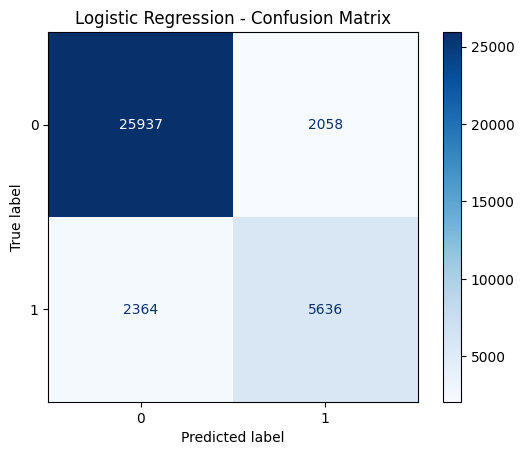

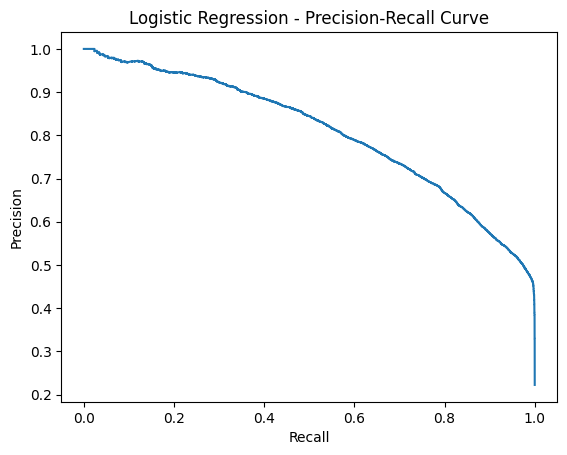


Evaluating model: AdaBoost
Training time for AdaBoost: 58.83 seconds
Accuracy: 0.9021, ROC-AUC: 0.9556, F1 Score: 0.7650


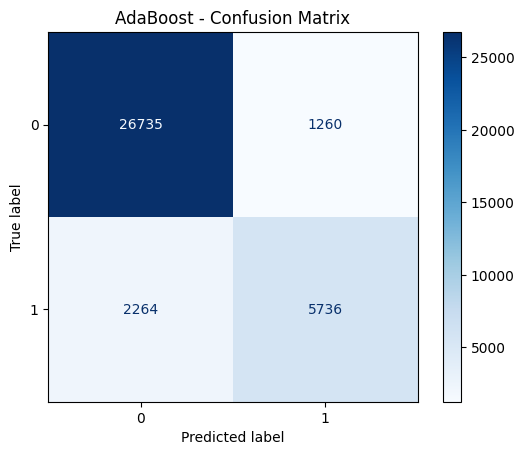

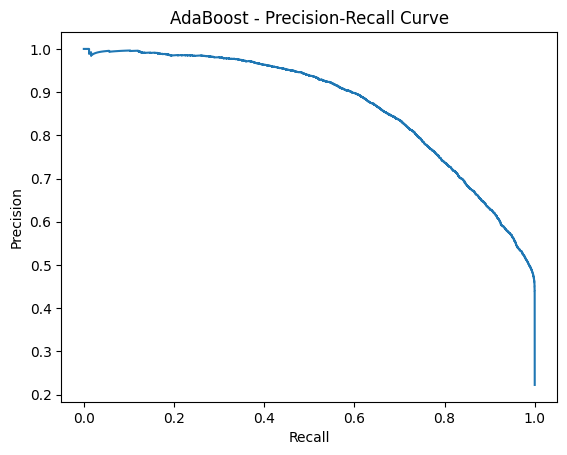


Evaluating model: LightGBM
Training time for LightGBM: 12.69 seconds
Accuracy: 0.9250, ROC-AUC: 0.9723, F1 Score: 0.8207


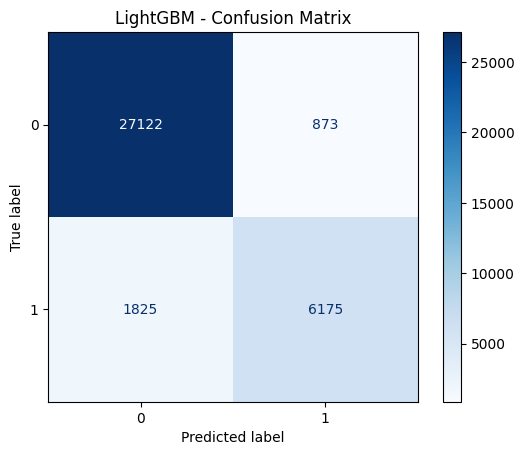

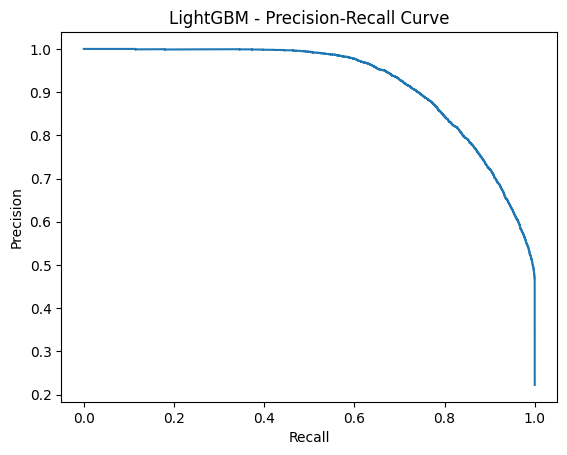


Evaluating model: CatBoost
Training time for CatBoost: 30.70 seconds
Accuracy: 0.9235, ROC-AUC: 0.9715, F1 Score: 0.8140


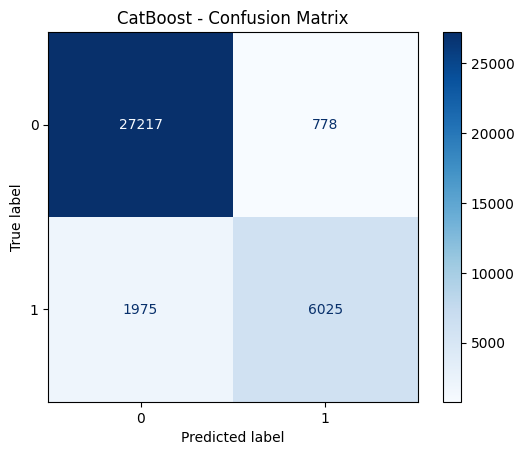

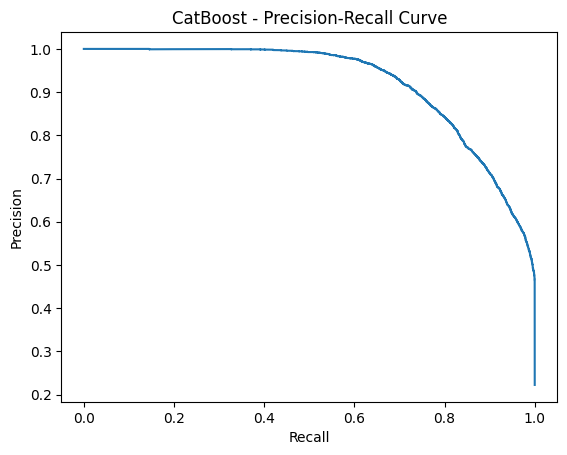


Evaluating model: XGBClassifier
Training time for XGBClassifier: 5.13 seconds
Accuracy: 0.9212, ROC-AUC: 0.9704, F1 Score: 0.8097


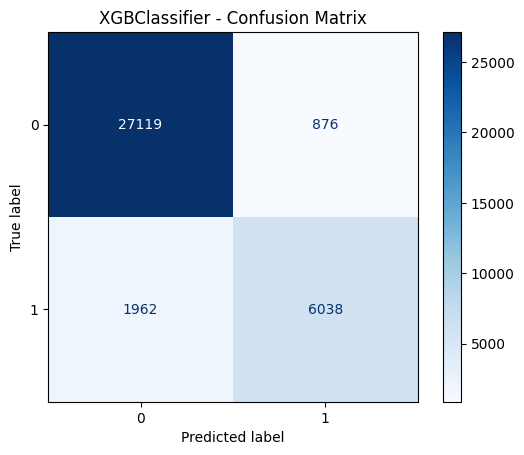

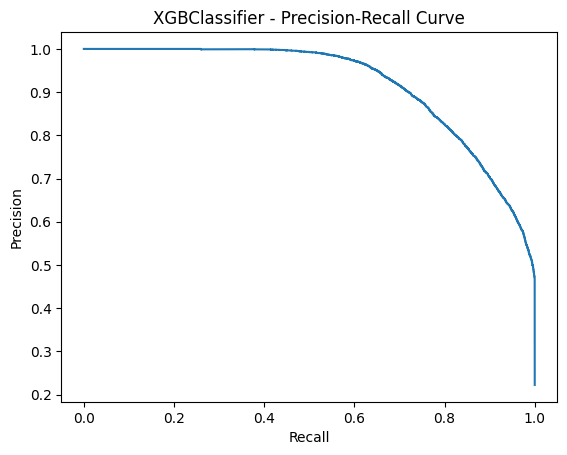

,Model,Accuracy,ROC-AUC,F1 Score,Confusion Matrix
0,Logistic Regression,0.877150,0.937522,0.718236,"[[25937, 2058], [2364, 5636]]"
1,AdaBoost,0.902098,0.955595,0.765004,"[[26735, 1260], [2264, 5736]]"
2,LightGBM,0.925045,0.972268,0.820707,"[[27122, 873], [1825, 6175]]"
3,CatBoost,0.923517,0.971461,0.814024,"[[27217, 778], [1975, 6025]]"
4,XGBClassifier,0.921156,0.970370,0.809709,"[[27119, 876], [1962, 6038]]"


In [25]:
evaluate_models(best_models, X_train, y_train)

## Ensamble Methods

In [26]:
voting_clf = VotingClassifier(
    estimators=[
    ("light_gbm", best_models["LightGBM"]),
    ("xgb", best_models["XGBClassifier"]),
    ("cat_boost", best_models["CatBoost"])
    ],
    voting="soft"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('light_gbm',
                              Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                            SimpleImputer(strategy='median')),
                                                                                           ('standardscaler',
                                                                                            StandardScaler())]),
                                                                 transformers=[('cat',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(drop='first',
                                                                                                               han...
                                                                                 'loan_percent_income']),
                                                                               ('rbf',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('functiontransformer',
                                                                                                 FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                     func=<function rbf_kernel at 0x78d3d1ab3490>,
                                                                                                                     kw_args={'Y': [[11.01]],
                                                                                                                              'gamma': 0.1}))]),
                                                                                ['loan_int_rate'])])),
                                              ('catboost',
                                               <catboost.core.CatBoostClassifier object at 0x78d39c871600>)]))],
                 voting='soft')

In [27]:
stacking_clf = StackingClassifier(
    estimators=[
    ("light_gbm", best_models["LightGBM"]),
    ("xgb", best_models["XGBClassifier"]),
    ("cat_boost", best_models["CatBoost"])
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=stratified_cv
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('light_gbm',
                                Pipeline(steps=[('preprocessing',
                                                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                              SimpleImputer(strategy='median')),
                                                                                             ('standardscaler',
                                                                                              StandardScaler())]),
                                                                   transformers=[('cat',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='mo...
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('functiontransformer',
                                                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                       func=<function rbf_kernel at 0x78d3d1ab3490>,
                                                                                                                       kw_args={'Y': [[11.01]],
                                                                                                                                'gamma': 0.1}))]),
                                                                                  ['loan_int_rate'])])),
                                                ('catboost',
                                                 <catboost.core.CatBoostClassifier object at 0x78d39c871600>)]))],
                   final_estimator=RandomForestClassifier(random_state=43))

## Model Testing

In [28]:
test_set_new = test_set.copy()
test_set_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 10750 to 34694
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      9000 non-null   float64
 1   person_gender                   9000 non-null   object 
 2   person_education                9000 non-null   object 
 3   person_income                   9000 non-null   float64
 4   person_emp_exp                  9000 non-null   int64  
 5   person_home_ownership           9000 non-null   object 
 6   loan_amnt                       9000 non-null   float64
 7   loan_intent                     9000 non-null   object 
 8   loan_int_rate                   9000 non-null   float64
 9   loan_percent_income             9000 non-null   float64
 10  cb_person_cred_hist_length      9000 non-null   float64
 11  credit_score                    9000 non-null   int64  
 12  previous_loan_defaults_on_file  90

In [29]:
filtered_test_set = test_set_new[test_set_new["person_age"] <= 100]

filtered_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8998 entries, 10750 to 34694
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      8998 non-null   float64
 1   person_gender                   8998 non-null   object 
 2   person_education                8998 non-null   object 
 3   person_income                   8998 non-null   float64
 4   person_emp_exp                  8998 non-null   int64  
 5   person_home_ownership           8998 non-null   object 
 6   loan_amnt                       8998 non-null   float64
 7   loan_intent                     8998 non-null   object 
 8   loan_int_rate                   8998 non-null   float64
 9   loan_percent_income             8998 non-null   float64
 10  cb_person_cred_hist_length      8998 non-null   float64
 11  credit_score                    8998 non-null   int64  
 12  previous_loan_defaults_on_file  89

In [30]:
X_test = filtered_test_set.drop(["loan_status"], axis=1)
y_test = filtered_test_set["loan_status"].copy()


Evaluating model: VotingClassifier
Training time for VotingClassifier: 24.15 seconds
Accuracy: 0.9129, ROC-AUC: 0.9634, F1 Score: 0.7881


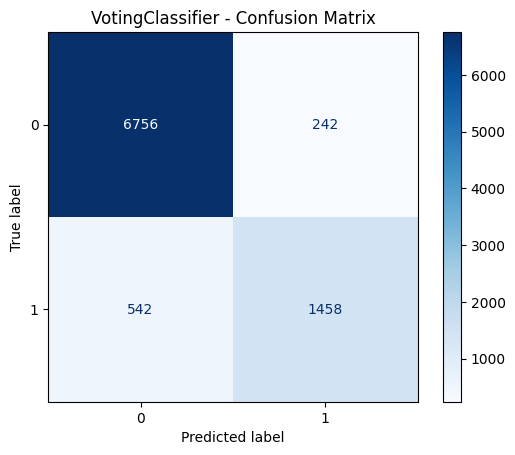

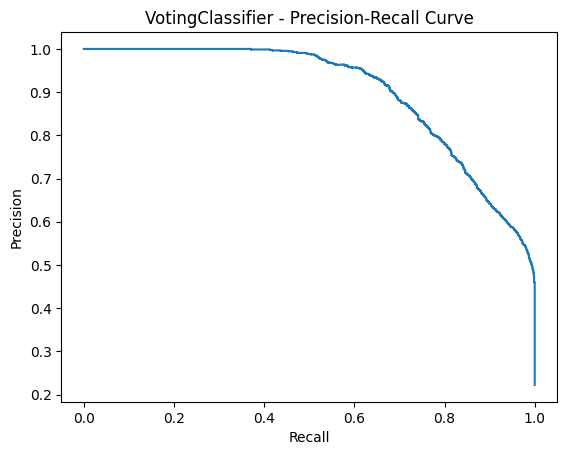


Evaluating model: StackingClassifier
Training time for StackingClassifier: 142.76 seconds
Accuracy: 0.9063, ROC-AUC: 0.9539, F1 Score: 0.7715


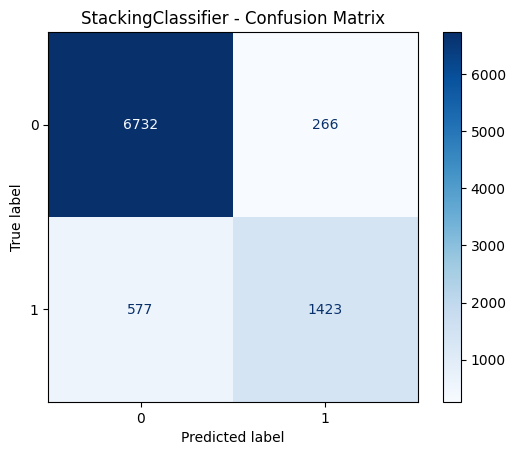

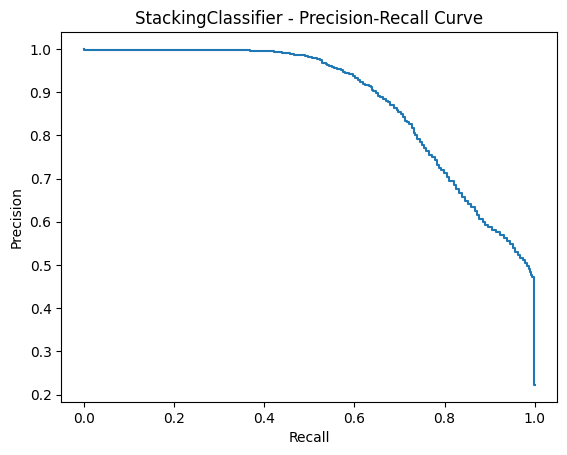

,Model,Accuracy,ROC-AUC,F1 Score,Confusion Matrix
0,VotingClassifier,0.912870,0.963424,0.788108,"[[6756, 242], [542, 1458]]"
1,StackingClassifier,0.906313,0.953933,0.771483,"[[6732, 266], [577, 1423]]"


In [31]:
models = {
    "VotingClassifier": voting_clf,
    "StackingClassifier": stacking_clf
}

results_df = evaluate_models(models, X_test, y_test)

results_df.head()

## Model Exporting

In [32]:
joblib.dump(voting_clf, "loan_approval_model.pkl")

['loan_approval_model.pkl']